# waypoints

## define agents

In [1]:
class FGAgent:
    def __init__(self, bubble_r=0.5, lookahead_degrees=[90., 270.], speed=2.0):
        self.bubble_r = bubble_r
        self.lookahead_degrees = lookahead_degrees
        self.speed = speed
        
    def get_action(self, state):
        ranges = state[:360]
        #print(ranges[10], ranges[90], ranges[180], ranges[270], ranges[350])
        beg = int(self.lookahead_degrees[0])
        end = int(self.lookahead_degrees[1])

        ranges = ranges[beg:end]

        ranges = np.clip(ranges, 0, 10.0)
        
        nearest_point = np.min(ranges)
        min_dist = nearest_point + self.bubble_r

        ranges = np.where(ranges <= min_dist, 0.0, ranges)

        gaps = []
        if ranges[0] != 0.0:
            gaps.append(0)

        i = 0
        while i < len(ranges):
            if ranges[i] == 0.0:
                if i > 0:
                    gaps.append(i-1)
                while i < len(ranges) and ranges[i] == 0.0:
                    i += 1
                if i < len(ranges):
                    gaps.append(i)
                continue

            i += 1

        if ranges[-1] != 0.0:
            gaps.append(len(ranges) - 1)

        assert len(gaps) % 2 == 0

        max_gap = -1
        gap_beg = 0
        gap_end = 360

        # find max gap
        i = 0
        while i < len(gaps):
            if gaps[i+1]-gaps[i] > max_gap:
                max_gap = gaps[i+1]-gaps[i]
                gap_beg = gaps[i]+beg
                gap_end = gaps[i+1]+beg
            i += 2

        mid_point = float(gap_end+gap_beg)/2.
        angle_deg = mid_point - 180
        angle_rad = angle_deg * (np.pi/180.)
#         print(f"midpoint:{mid_point}")
        angle = angle_rad * 1.0
        return [angle, self.speed]



In [3]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class WPEnv(gym.Env):
    
    def __init__(self, map_name='', begin_pos=None):
        self.map_name = map_name
        self.begin_pos = begin_pos
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"../maps/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(render_callback)
        
        begin_pos = [0, 0, 0] if self.begin_pos is None else self.begin_pos
        obs, step_reward, done, info = self.env.reset(np.array([begin_pos]))
 
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, 10)
        buck = 3
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
                
        state = [
            agg_scanner,
            np.array(obs['linear_vels_x'][0]),
            np.array(obs['ang_vels_z'][0]),
            (obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0])
        ]

        return state
    
        
    def step(self, action):
        act = np.array([action])
        reward = 0
        obs, step_reward, done, info = self.env.step(act)
        
        if obs['collisions'][0] == 1.0:
            print("CRASHED")
            done = True
            reward = -1
        
                
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            print("DONE")
            done = True
        
        next_state = self.to_vector_state(obs)
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

WPEnv(map_name='SILVERSTONE')

## create waypoints

In [4]:

done = False
env = WPEnv(map_name='in_lab1', begin_pos=[0, 0, np.pi+1])
obs = env.reset()
agent = FGAgent(speed=3.0)

positions = []

while not done:
    positions.append(obs[3])
    th, v = agent.get_action(obs[0])
    obs, r, done, _ = env.step([th, v])
#     env.render()

DONE


In [28]:
with open('../maps/inlab1_wp.np', 'wb') as f:
    np.save(f, positions)

## analyze waypoints

In [29]:
import numpy as np

with open('../maps/inlab1_wp.np', 'rb') as f:
    wps = np.load(f)
    
dist = np.linalg.norm(wps[0][:2] - wps[100][:2])
print(dist)
print(len(wps))
print(len(wps)//100)

2.2864382490238477
4599
45


In [17]:
from tqdm import tqdm

map_name = 'in_lab1'
env = gym.make('f110_gym:f110-v0', map=f"../maps/{map_name}", map_ext='.png', num_agents=1)

for wp in tqdm(wps):
    obs, step_reward, done, info = env.reset(
        np.array([
            wp
        ])
    )
    if min(obs['scans'][0]) < 0.5:
        print(min(obs['scans'][0]))
        

100%|██████████| 4599/4599 [00:01<00:00, 2306.61it/s]


In [44]:
from scipy.spatial.distance import cdist

x = cdist([[0,0]], wps[:,:2])
np.argmin(x)

0

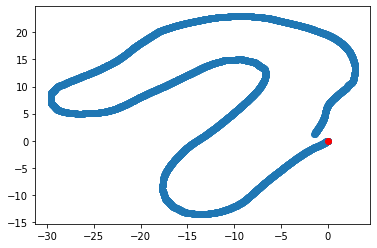

In [19]:
import matplotlib.pyplot as plt

plt.scatter(wps[:,0], wps[:, 1])
plt.scatter(wps[0,0], wps[0,1], c='r')

# environment

In [41]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=5.0,
                 n_cps = 100,
                 cp_reward = 0.1,
                 min_cp_dist=2.0,
                 maps_path='../maps',
                 models_path='../checkpoints',
                 train_map_name='in_lab',
                 safe_padding=0.3,
                 laps = 1.0
                ):
        
        self.laps = laps
        self.maps_path = maps_path
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(110,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
    
    def _render_callback(self, env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800
  
    def load_train_setup(self):
        no = np.random.choice([1])
        
        map_path = f"{self.maps_path}/{self.train_map_name}{no}"
        with open(f'{self.maps_path}/inlab{no}_wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"{self.maps_path}/{self.test_map_name}"
        with open(f'{self.maps_path}/inlab1_wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
        self.cum_r = 0
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(self._render_callback)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
#         print(f"number of checkpoints: {len(self.checkpoints)}")
        
        if self.test_map_name is None:
            start_idx = np.random.randint(0, len(self.checkpoints))
            start_point = self.checkpoints[start_idx]
            
        else:
#             dists = cdist([[0,0]], np.array(self.checkpoints)[:,:2])
#             start_idx = np.argmin(dists)
#             start_point = [0., 0., np.pi+1]
            start_idx = np.random.randint(0, len(self.checkpoints))
            start_point = self.checkpoints[start_idx]
            
        self.next_cp_idx = (start_idx + 2)%len(self.checkpoints)
            
        
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point
            ])
        )
        
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, self.scan_range)
        
        buck = 10
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
#         if self.test_map_name is None:
#             noise = np.random.normal(loc=0.0, scale=0.03, size=state.shape)
#             state = state + noise
        
        return state
    
    def checkpoint(self, position):
        return_cp_idx = (self.next_cp_idx - 5)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        
        
        th = action[1]*np.pi/6
        act = np.array([[th, act_v]])

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        next_state = self.to_vector_state(obs)
        position = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            if self.test_map_name is not None:
                print('CRASHED')
            return next_state, reward, done, {}
            
        cp_reward = self.checkpoint(position)
        reward += cp_reward
        self.t += 1
        
        if obs['lap_counts'][0] == self.laps:
            t = obs['lap_times'][0]  
#             reward = np.exp(2.5 - 0.05*t)
#             fairlap = 60
#             reward = max(0.2*(fairlap - t), self.cp_reward)
            reward = self.cp_reward
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            done = True
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.max(self.prev_vel)<3.0:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
        if np.min(obs['scans'][0]) < self.safe_padding:
            reward += -0.05
            self.total_padding_punish -= 0.05
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset()

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.28228996, 0.25264511, 0.2530822 , 0.24554839,
       0.2381688 , 0.23796707, 0.23911394, 0.23714355, 0.24582891,
       0.2549026 , 0.25338222, 0.26199587, 0.27780611, 0.29371171,
       0.30200931, 0.30725817, 0.32382061, 0.33395685, 0.36843971,
       0.41229792, 0.4364168 , 0.45597292, 0.49583114, 0.55836213,
       0.70195619, 0.861361  , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.96824461, 0.92787208, 0.87442421, 0.83589977,
       0.78473533, 0.74563453, 0.71788064, 0.69987494, 0.66690528,
       0.63050014, 0.61819075, 0.6037407 , 0.59022541, 0.58102856,
       0.56408033, 0.53699235, 0.51244231, 0.49175348, 0.47441

# training

In [33]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [35]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()



# with half cheeta configs

hc_configs = {
    'framework': 'torch',
    'num_workers': 15,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300],
    },
    'num_envs_per_worker': 1,
    'train_batch_size': 10000,
    'sgd_minibatch_size': 512,
    'batch_mode': 'truncate_episodes',
    'lr': .0003,
}


trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
# print("FINE TUNING")
# trainer.restore('../checkpoints/v2.2/checkpoint_000031/checkpoint-31')

print(trainer.config)
rewards = []
best_reward = -100
models_path = '../checkpoints'

import pickle

for i in range(100):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open(f'{models_path}/phy_v1.0_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0 and episode_r > best_reward:
        best_reward = episode_r
        cp = trainer.save(f"{models_path}/phy_v1.0")
        print("checkpoint saved at", cp)


2022-04-15 15:48:59,447	WARNING ppo.py:223 -- `train_batch_size` (10000) cannot be achieved with your other settings (num_workers=15 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 666.
2022-04-15 15:48:59,448	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-15 15:48:59,449	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=48421) 2022-04-15 15:49:07,241	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=48444) 2022-04-15 15:49:07,230	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorE

{'num_workers': 15, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 666, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0003, 'train_batch_size': 10000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [300, 300], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_pr

(RolloutWorker pid=48442) agent on ../maps/in_lab1 got reward 0.2 in 0.9000000000000006. RETURNED
(RolloutWorker pid=48421) agent on ../maps/in_lab1 got reward 0.30000000000000004 in 1.430000000000001. RETURNED
(RolloutWorker pid=48429) agent on ../maps/in_lab1 got reward 0.1 in 0.03. RETURNED
(RolloutWorker pid=48444) agent on ../maps/in_lab1 got reward 0.7999999999999999 in 4.369999999999951. RETURNED


2022-04-15 15:49:23,263	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:-0.8970588235294118
checkpoint saved at ../checkpoints/phy_v1.0/checkpoint_000001/checkpoint-1
(RolloutWorker pid=48422) agent on ../maps/in_lab1 got reward 0.2 in 1.2500000000000009. RETURNED
(RolloutWorker pid=48438) agent on ../maps/in_lab1 got reward 0.1 in 0.03. RETURNED
episode: 1 reward:-0.8992537313432837
(RolloutWorker pid=48421) agent on ../maps/in_lab1 got reward 0.4 in 1.9600000000000015. RETURNED
(RolloutWorker pid=48431) agent on ../maps/in_lab1 got reward 1.6000000000000003 in 9.959999999999832. RETURNED
(RolloutWorker pid=48440) agent on ../maps/in_lab1 got reward 0.7999999999999999 in 4.239999999999954. RETURNED
(RolloutWorker pid=48429) agent on ../maps/in_lab1 got reward 0.6 in 2.9799999999999804. RETURNED
episode: 2 reward:-0.8402173913043477
(RolloutWorker pid=48441) agent on ../maps/in_lab1 got reward 1.0999999999999999 in 6.649999999999903. RETURNED
(RolloutWorker pid=48431) agent on ../maps/in_lab1 got reward 1.7000000000000004 in 10.3499999999

(RolloutWorker pid=48422) agent on ../maps/in_lab1 got reward 0.7 in 3.3499999999999726. RETURNED
(RolloutWorker pid=48439) agent on ../maps/in_lab1 got reward 1.5000000000000002 in 8.439999999999864. RETURNED
(RolloutWorker pid=48421) agent on ../maps/in_lab1 got reward 1.7000000000000004 in 8.369999999999866. RETURNED
(RolloutWorker pid=48441) agent on ../maps/in_lab1 got reward 1.0999999999999999 in 6.569999999999904. RETURNED
(RolloutWorker pid=48435) agent on ../maps/in_lab1 got reward 1.8000000000000005 in 8.299999999999867. RETURNED
(RolloutWorker pid=48434) agent on ../maps/in_lab1 got reward 6.499999999999993 in 33.340000000001936. RETURNED
episode: 12 reward:0.3119999999999999
(RolloutWorker pid=48409) agent on ../maps/in_lab1 got reward 2.9000000000000012 in 15.71999999999971. RETURNED
(RolloutWorker pid=48441) agent on ../maps/in_lab1 got reward 1.3 in 6.009999999999916. RETURNED
(RolloutWorker pid=48437) agent on ../maps/in_lab1 got reward 2.600000000000001 in 56.409999999

(RolloutWorker pid=48440) agent on ../maps/in_lab1 got reward 3.600000000000002 in 22.45000000000071. RETURNED
(RolloutWorker pid=48438) agent on ../maps/in_lab1 got reward 0.15000000000000002 in 61.999999999996234. RETURNED
(RolloutWorker pid=48442) agent on ../maps/in_lab1 got reward 1.2 in 6.829999999999899. RETURNED
(RolloutWorker pid=48431) agent on ../maps/in_lab1 got reward 6.499999999999993 in 38.91000000000083. RETURNED
episode: 24 reward:1.8164999999999996
(RolloutWorker pid=48442) agent on ../maps/in_lab1 got reward 1.5000000000000002 in 8.299999999999867. RETURNED
(RolloutWorker pid=48429) agent on ../maps/in_lab1 got reward 0.6 in 4.509999999999948. RETURNED
(RolloutWorker pid=48442) agent on ../maps/in_lab1 got reward 1.8000000000000005 in 10.819999999999814. RETURNED
episode: 25 reward:1.7859999999999996
checkpoint saved at ../checkpoints/phy_v1.0/checkpoint_000026/checkpoint-26
(RolloutWorker pid=48439) agent on ../maps/in_lab1 got reward 4.799999999999999 in 67.4799999

(RolloutWorker pid=48422) agent on ../maps/in_lab1 got reward 1.3 in 7.199999999999891. RETURNED
(RolloutWorker pid=48434) agent on ../maps/in_lab1 got reward 2.2000000000000006 in 13.82999999999975. RETURNED
(RolloutWorker pid=48438) agent on ../maps/in_lab1 got reward 1.5000000000000002 in 64.6999999999962. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=48431) agent on ../maps/in_lab1 got reward 8.799999999999985 in 55.309999999997565. RETURNED
(RolloutWorker pid=48441) agent on ../maps/in_lab1 got reward 4.300000000000001 in 27.850000000001554. RETURNED
episode: 34 reward:2.2739999999999987
(RolloutWorker pid=48422) agent on ../maps/in_lab1 got reward 2.1000000000000005 in 13.969999999999747. RETURNED
(RolloutWorker pid=48442) agent on ../maps/in_lab1 got reward 6.199999999999994 in 39.67000000000068. RETURNED
(RolloutWorker pid=48437) agent on ../maps/in_lab1 got reward 2.700000000000001 in 17.950000000000006. RETURNED
(RolloutWorker pid=48439) agent on ../maps/in_lab1 go

(RolloutWorker pid=48409) agent on ../maps/in_lab1 got reward 6.5999999999999925 in 35.450000000001516. RETURNED
(RolloutWorker pid=48441) agent on ../maps/in_lab1 got reward 0.8999999999999999 in 5.1099999999999355. RETURNED
(RolloutWorker pid=48442) agent on ../maps/in_lab1 got reward 1.8000000000000005 in 10.189999999999827. RETURNED
(RolloutWorker pid=48435) agent on ../maps/in_lab1 got reward 5.599999999999996 in 29.920000000001878. RETURNED
(RolloutWorker pid=48422) agent on ../maps/in_lab1 got reward 1.7000000000000004 in 9.429999999999843. RETURNED
episode: 43 reward:2.6674999999999973
(RolloutWorker pid=48440) agent on ../maps/in_lab1 got reward 2.800000000000001 in 56.95999999999724. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=48440) agent on ../maps/in_lab1 got reward 0 in 0.02. RETURNED
(RolloutWorker pid=48442) agent on ../maps/in_lab1 got reward 4.5 in 21.660000000000586. RETURNED
episode: 44 reward:2.6134999999999975
(RolloutWorker pid=48422) agent on ../map

(RolloutWorker pid=48435) agent on ../maps/in_lab1 got reward 0 in 0.02. RETURNED
(RolloutWorker pid=48438) agent on ../maps/in_lab1 got reward 1.4000000000000001 in 53.15999999999799. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=48435) agent on ../maps/in_lab1 got reward 0.9999999999999999 in 4.289999999999953. RETURNED
(RolloutWorker pid=48409) agent on ../maps/in_lab1 got reward 4.899999999999999 in 24.780000000001074. RETURNED
(RolloutWorker pid=48437) agent on ../maps/in_lab1 got reward 2.500000000000001 in 13.699999999999752. RETURNED
(RolloutWorker pid=48441) agent on ../maps/in_lab1 got reward 1.2 in 5.679999999999923. RETURNED
(RolloutWorker pid=48440) agent on ../maps/in_lab1 got reward 2.0000000000000004 in 10.149999999999828. RETURNED
(RolloutWorker pid=48436) agent on ../maps/in_lab1 got reward 5.599999999999996 in 31.40000000000211. RETURNED
episode: 54 reward:1.805499999999999
(RolloutWorker pid=48441) agent on ../maps/in_lab1 got reward 1.3 in 7.349999999999

KeyboardInterrupt: 

In [34]:
!rm -rf ../checkpoints/phy_v1.0

## evaluation

In [36]:
import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('../checkpoints/phy_v1.0/checkpoint_000046/checkpoint-46')



2022-04-15 16:00:00,967	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
2022-04-15 16:00:00,970	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-04-15 16:00:00,978	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/phy_v1.0/checkpoint_000046/checkpoint-46
2022-04-15 16:00:00,978	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 46, '_timesteps_total': 919080, '_time_total': 487.95474314689636, '_episodes_total': 413}


In [45]:
done = False
env = F110RaceEnv({}, test_map_name='in_lab1', laps=1)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

agent on ../maps/in_lab1 got reward 1.2 in 5.229999999999933. STOPPED
lap: [5.23]
reward:0.19999999999999996


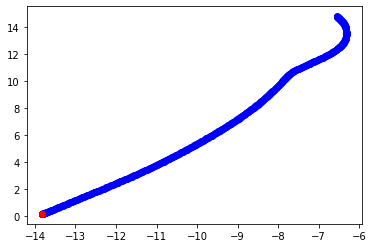

In [46]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])
plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')

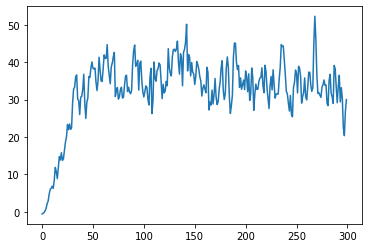

In [44]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/race_v1.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

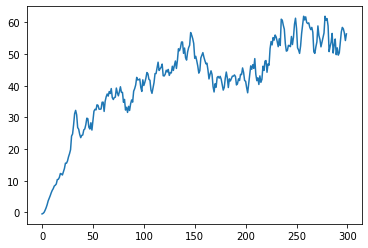

In [4]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/v1.2_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

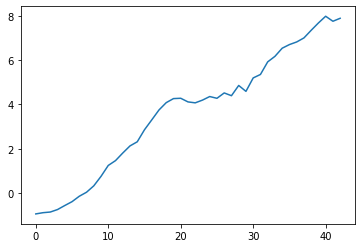

In [5]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/v2.3_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
